**<font size="5">Applied Statistics</font>**

<font size="3">MSc in High Performance Computing Engineering, Computer Science and Engineering, Physics Engineering - A.Y. 2024-2025</font>

Prof. Mario Beraha - Dott. Vittorio Torri

---

<font size="4">**Lab 7 - Logistic Regression**</font>

# Libraries

In [2]:
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import numpy as np

In [5]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [6]:
import statsmodels.api as sm

In [7]:
np.random.seed(1234)

In [8]:
import scipy.stats as stats

# Load Dataset

In [9]:
df = pd.read_csv('../DatasetsLabs/heart_failure_clinical_records_dataset_smhd.csv')  # Adjust the path as necessary

In [10]:
cat_vars = ['anaemia', 'diabetes', 'high_blood_pressure',  'sex',  'smoking',  'DEATH_EVENT']
num_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium', 'bmi', 'time']

# Binary Logistic Regression

We want to build a model to classify patients as dead or survived during follow-up: binary classification.

We use a logistic regression model, which models the probability of the positive class (death) in the following way, where $x_1, ..., x_p$ are the input variables

$$
P(y = 1 | x) = \frac{1}{1 + e^{-(\beta_0 + \beta_1 x_1 + \beta_2 x_2 + \dots + \beta_p x_p)}}
$$


## Model

In [11]:
X = df[['age', 'bmi', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'high_blood_pressure', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'ejection_fraction', 'time']]
y = df['DEATH_EVENT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=1234)

train_index = X_train.index
test_index = X_test.index

We start using all numerical variables

In [12]:
X_train_1 = X_train[num_vars]
X_test_1 = X_test[num_vars]

# Fit the logistic regression model
logit_model = sm.Logit(y_train, X_train_1).fit()

print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.376649
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            DEATH_EVENT   No. Observations:                  239
Model:                          Logit   Df Residuals:                      231
Method:                           MLE   Df Model:                            7
Date:                Sun, 13 Jul 2025   Pseudo R-squ.:                  0.4036
Time:                        15:46:11   Log-Likelihood:                -90.019
converged:                       True   LL-Null:                       -150.95
Covariance Type:            nonrobust   LLR p-value:                 3.151e-23
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
age                          0.0501      0.017      2.979      0.003       0.017

By default statsmodels uses the Newton-Raphson iterative optimization method to maximize the likelihood, but other methods can be specified

Statsmodels compute the pseudo R^2 statistics using the McFadden's definition:

$$pseudo_{R^2} = 1 - \frac{LL}{LL_{Null}}$$

It has values from 0 to 1 and it indicates the goodness of the model, but it's not the primary metric used to evaluate LR models

## Odds Ratios

L'odd ratio è P/1-P cioè la probabilità che l'evento accade diviso la probabilità che l'evento non accade. L'odd ratio per una variabile è e^(coefficient), quindi:
- odds ratio = 1 la variabile non ha effetto (coefficient = 0)
- > 1 la variabile aumenta la prob dell'evneto
- < 1 la variabile diminuisce la prob dell'evneto

In a logistic model, the effect of the coefficient is different from a linear regression model. A k-unit increase in $x_j$ increases the risk by a factor of $exp(k \cdot \hat{\beta_j})$. Odds ratios are defined as:

$$
OR_j = exp(\hat{\beta_j})
$$

In [13]:
coef = logit_model.params
odds_ratios = np.exp(coef)

conf = logit_model.conf_int()
conf.columns = ['2.5%', '97.5%']
conf = np.exp(conf)  # Exponentiate to get ORs' CIs

or_summary = pd.DataFrame({
    "Coefficient": coef,
    "Odds Ratio": odds_ratios,
    "2.5% CI OR": conf['2.5%'],
    "97.5% CI OR": conf['97.5%']
})

print(or_summary)

                          Coefficient  Odds Ratio  2.5% CI OR  97.5% CI OR
age                              0.05        1.05        1.02         1.09
creatinine_phosphokinase         0.00        1.00        1.00         1.00
ejection_fraction               -0.05        0.95        0.91         0.99
platelets                       -0.00        1.00        1.00         1.00
serum_creatinine                 0.52        1.69        0.88         3.24
serum_sodium                    -0.01        0.99        0.95         1.03
bmi                              0.07        1.07        0.91         1.27
time                            -0.02        0.98        0.97         0.99


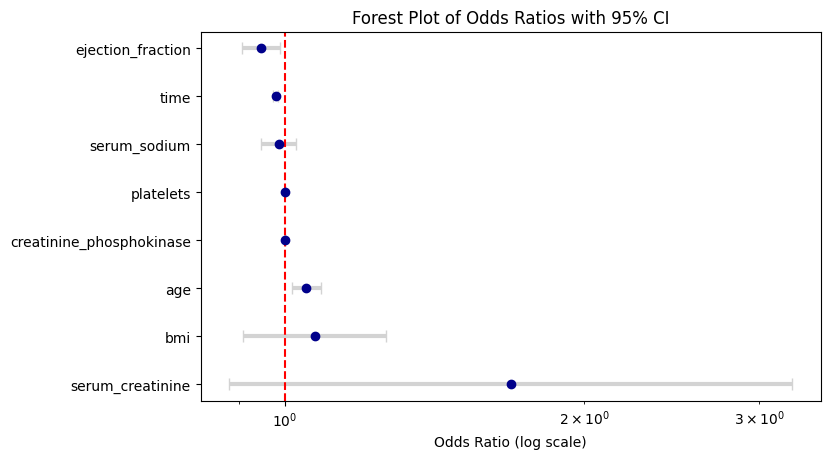

In [14]:
# Sort by odds ratio for better visualization
or_summary = or_summary.sort_values(by="Odds Ratio", ascending=False)

fig, ax = plt.subplots(figsize=(8, len(or_summary) * 0.6))

# Plot the OR as points
ax.errorbar(or_summary['Odds Ratio'], or_summary.index,
            xerr=[or_summary['Odds Ratio'] - or_summary['2.5% CI OR'], or_summary['97.5% CI OR'] - or_summary['Odds Ratio']],
            fmt='o', color='darkblue', ecolor='lightgray', elinewidth=3, capsize=4)

# Add a vertical line at OR = 1 (no effect)
ax.axvline(1, color='red', linestyle='--')

# Set labels
ax.set_xlabel("Odds Ratio (log scale)")
ax.set_title("Forest Plot of Odds Ratios with 95% CI")
ax.set_xscale("log")  # Log scale for better visualization

plt.show()

Infatti come si può notare all'aumentare della age, si avrà sempre un aumento della probabilità di morte

## Confusion Matrix

In [15]:
from sklearn.metrics import confusion_matrix

In [16]:
y_test_pred_prob = logit_model.predict(X_test_1)

In [17]:
y_test_pred_prob

73    0.28
110   0.27
291   0.02
168   0.17
289   0.03
124   0.81
286   0.03
164   0.29
296   0.00
261   0.01
138   0.37
166   0.03
66    0.58
69    0.70
101   0.32
7     0.26
260   0.01
145   0.20
287   0.00
112   0.59
163   0.17
100   0.58
40    0.93
6     0.95
22    0.74
223   0.05
213   0.05
108   0.45
283   0.03
132   0.20
106   0.28
234   0.02
186   0.01
149   0.20
273   0.01
235   0.03
74    0.76
227   0.04
274   0.04
31    0.94
127   0.04
156   0.15
125   0.08
181   0.30
221   0.03
242   0.01
229   0.08
170   0.15
276   0.03
99    0.37
29    0.87
80    0.56
67    0.72
210   0.27
93    0.68
241   0.07
205   0.03
122   0.12
244   0.05
162   0.12
dtype: float64

In [18]:
# Convert probabilities to binary outcomes based on a threshold
threshold = 0.5
y_test_pred_class = (y_test_pred_prob > threshold).astype(int)

In [20]:
print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred_class))

Confusion Matrix on Test Set:
[[39  3]
 [ 7 11]]


With a more nice visualization:

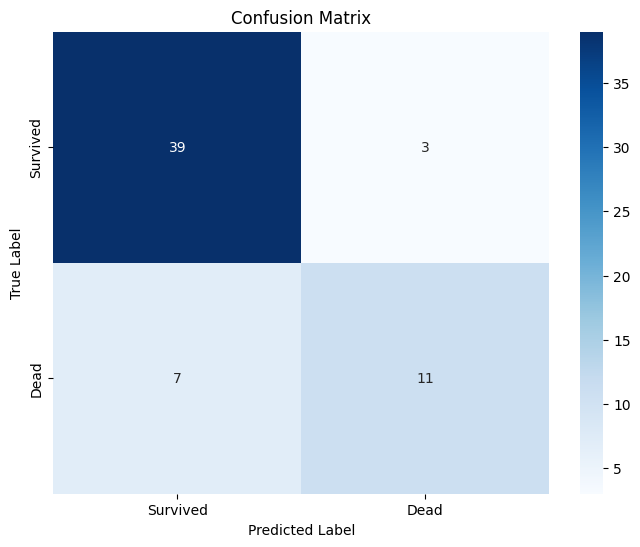

In [21]:
cm = confusion_matrix(y_test, y_test_pred_class)

class_names = ['Survived', 'Dead']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

[  TN    FP  
   FN    TP]

## AUC

The Receiver-Operating-Characteristic Curve (ROC Curve) plots the FPR vs TPR at varying the classification threshold from 0 to 1, where

$$TPR = \frac{TP}{TP+FN} (= Sensitivity = Recall)$$

$$FPR = \frac{FP}{FP+TN}$$

The ideal point is (0,1), which maximizes the TPR and minimizes the FPR

The Area Under the Curve (AUC) is a measure of goodness of the model that is not influences by the choice of a classification threshold

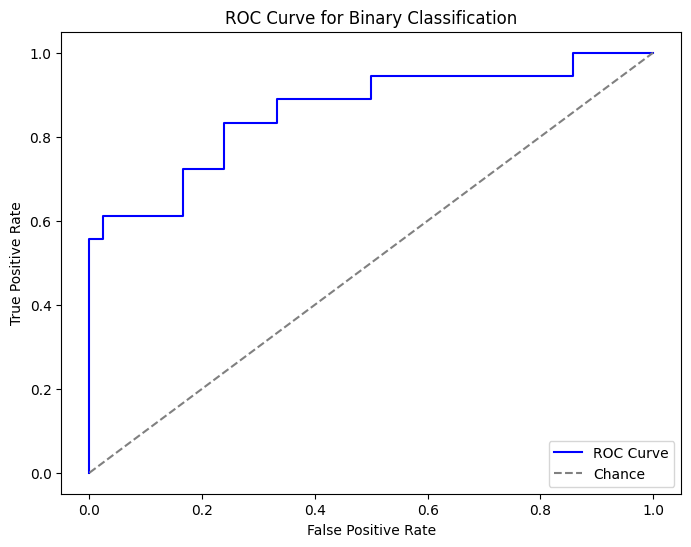

In [22]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_test, y_test_pred_prob)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve")

# Plot the diagonal line representing random chance
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Chance")

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Binary Classification")
plt.legend(loc="lower right")
plt.show()


In [23]:
from sklearn.metrics import roc_auc_score

auc_score = roc_auc_score(y_test, y_test_pred_prob)
print(f"ROC-AUC Score on Test Set: {auc_score}")

ROC-AUC Score on Test Set: 0.8597883597883599


## Accuracy, Precision, Recall/Sensitivity, F1-Score, Specificity

$$Accuracy = \frac{TP+TN}{TP+FP+TN+FN}$$
$$Precision = \frac{TP}{TP+FP}$$
$$Recall = Sensitivity = \frac{TP}{TP+FN}$$
$$\text{F1-Score} = \frac{2 \cdot Precision \cdot Recall}{Precision + Recall}$$
$$Specificity = \frac{TN}{TN+FP}$$

In [24]:
from sklearn.metrics import classification_report

print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred_class, target_names=['Survived', 'Dead']))


Classification Report on Test Set:
              precision    recall  f1-score   support

    Survived       0.85      0.93      0.89        42
        Dead       0.79      0.61      0.69        18

    accuracy                           0.83        60
   macro avg       0.82      0.77      0.79        60
weighted avg       0.83      0.83      0.83        60



In [25]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_test_pred_class)
cm

array([[39,  3],
       [ 7, 11]])

In [26]:
## TODO: try to compute the specificity from the confusion matrix
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp) #percentuale di negativi che

print(f"Specificity on Test Set: {specificity}") # It is the recall of class that we defined as negative (Survived)

Specificity on Test Set: 0.9285714285714286


## Choice of the threshold

Using 0.5 as threshold is the most common choice, but it might not be the optimal one, especially in case of class unbalance

One suggest value is the percentage of negative samples

In [27]:
optimal_threshold_1 = 1 - df['DEATH_EVENT'].mean() # 1 - % of positive samples

In [28]:
optimal_threshold_1

np.float64(0.6789297658862876)

In [29]:
y_test_pred_class = (y_test_pred_prob > optimal_threshold_1).astype(int)

print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, y_test_pred_class))

Confusion Matrix on Test Set:
[[42  0]
 [ 9  9]]


In [30]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_class).ravel()

tpr_1 = tp / (tp + fn)  # Sensitivity or Recall or TPR
fpr_1 = fp / (fp + tn)  # False Positive Rate (FPR)

In [31]:
print("\nClassification Report on Test Set:")
print(classification_report(y_test, y_test_pred_class, target_names=['Survived', 'Dead']))


Classification Report on Test Set:
              precision    recall  f1-score   support

    Survived       0.82      1.00      0.90        42
        Dead       1.00      0.50      0.67        18

    accuracy                           0.85        60
   macro avg       0.91      0.75      0.78        60
weighted avg       0.88      0.85      0.83        60



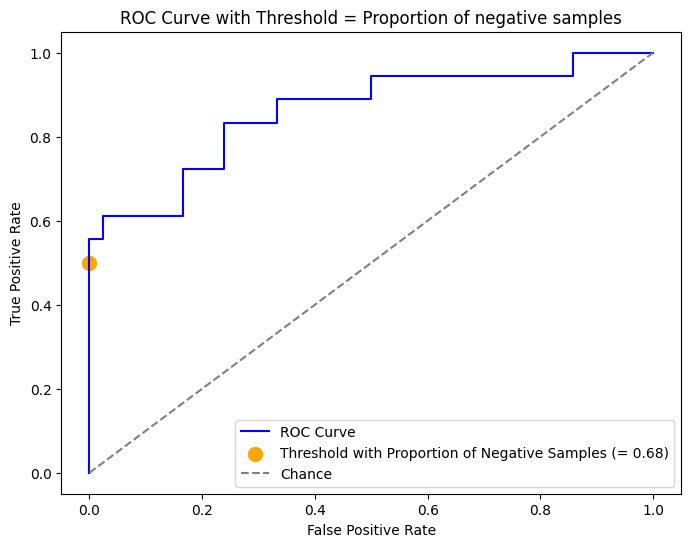

In [32]:
# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve")

# Plot the optimal threshold point
plt.scatter(fpr_1, tpr_1, color='orange', s=100, label=f"Threshold with Proportion of Negative Samples (= {optimal_threshold_1:.2f})")


# Plot the diagonal line representing random chance
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Chance")

# Labels and legend
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve with Threshold = Proportion of negative samples")
plt.legend(loc="lower right")
plt.show()

In [33]:
fpr, tpr, thresholds= roc_curve(y_test, y_test_pred_prob)
thresholds

array([           inf, 9.53908076e-01, 6.76273712e-01, 5.93853823e-01,
       5.77516053e-01, 3.24850371e-01, 2.85982628e-01, 2.73123438e-01,
       2.57326703e-01, 1.66578594e-01, 1.66227879e-01, 7.39754074e-02,
       4.85524201e-02, 1.74947868e-02, 1.38845912e-02, 3.97924223e-04])

In [34]:
#calcolare la roc curve per un valore del threshold dato
threshold = 0.5
probabilities = logit_model.predict(X_test_1)
y_pred = [1 if p>threshold else 0 for p in probabilities]
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

# fpr = fp / (fp + tn)
# tpr = tp / (tp + fn)
#oppure

fpr, tpr, thresholds = roc_curve(y_test, probabilities)
thresholds

array([           inf, 9.53908076e-01, 6.76273712e-01, 5.93853823e-01,
       5.77516053e-01, 3.24850371e-01, 2.85982628e-01, 2.73123438e-01,
       2.57326703e-01, 1.66578594e-01, 1.66227879e-01, 7.39754074e-02,
       4.85524201e-02, 1.74947868e-02, 1.38845912e-02, 3.97924223e-04])

# Multiclass logistic regression

We want to develop a model to classify HF patients in three ejection fraction classes

In [35]:
df['ef_cat'] = pd.cut(df['ejection_fraction'], bins=[0,40,50,100], labels=['reduced', 'mildly reduced', 'preserved'])

In [36]:
df[['ejection_fraction', 'ef_cat']]

,ejection_fraction,ef_cat
0,20.73,reduced
1,29.02,reduced
2,26.24,reduced
3,10.21,reduced
4,19.33,reduced
...,...,...
294,38.05,reduced
295,35.20,reduced
296,62.32,preserved
297,37.49,reduced


## Model

A multinomial logistic regression model assumes a baseline class (assume the *K*-th without loss of generality) and computes a set of coefficients for each other class *k*:

$$
P(y = k | x) = \frac{e^{\beta_{k0} + \beta_{k1} x_1 + \beta_{k2} x_2 + \dots + \beta_{kp} x_p}}{1 + \sum_{j=1}^{K-1} e^{\beta_{j0} + \beta_{j1} x_1 + \beta_{j2} x_2 + \dots + \beta_{jp} x_p}} \quad\text{for }k < K \\
P(y = K | x) = \frac{1}{1 + \sum_{j=1}^{K-1} e^{\beta_{j0} + \beta_{j1} x_1 + \beta_{j2} x_2 + \dots + \beta_{jp} x_p}}
$$

The multinomial logistic regression model implemented in the *statsmodels* library requires categorical input variables to be *one-hot encoded*

In [37]:
df_encoded = pd.get_dummies(df, columns=cat_vars, drop_first=True, dtype=int) # another way to apply one-hot encoding

In [ ]:

X = df_encoded[['age', 'bmi', 'serum_sodium', 'serum_creatinine', 'diabetes_1', 'sex_Male', 'smoking_1', 'high_blood_pressure_1', 'anaemia_1']]
y = df_encoded['ef_cat']  # Multiclass target variable

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y) #STRATIFICATION WITH RESPECT TO THE TARGET CLASS

model = sm.MNLogit(y_train, X_train)
result = model.fit()

result.predict(X_test)

Optimization terminated successfully.
         Current function value: 0.625371
         Iterations 8


,0,1,2
170,0.95,0.04,0.01
237,0.89,0.10,0.01
218,0.88,0.10,0.01
228,0.88,0.12,0.00
264,0.19,0.25,0.55
129,0.46,0.23,0.31
97,0.12,0.12,0.77
139,0.77,0.18,0.05
193,0.92,0.07,0.00
39,0.91,0.08,0.01


In [40]:
np.exp(result.params).rename(columns={0: 'mildly_reduced OR', 1:'preserved OR'})

,mildly_reduced OR,preserved OR
const,15812631.77,40511846878.96
age,1.02,1.00
bmi,0.71,0.41
serum_sodium,0.92,0.95
serum_creatinine,3.16,12.32
diabetes_1,0.92,1.83
sex_Male,1.59,0.94
smoking_1,0.70,1.42
high_blood_pressure_1,0.96,0.74
anaemia_1,0.61,1.37


In [41]:
model._ynames_map

{0: 'reduced', 1: 'mildly reduced', 2: 'preserved'}

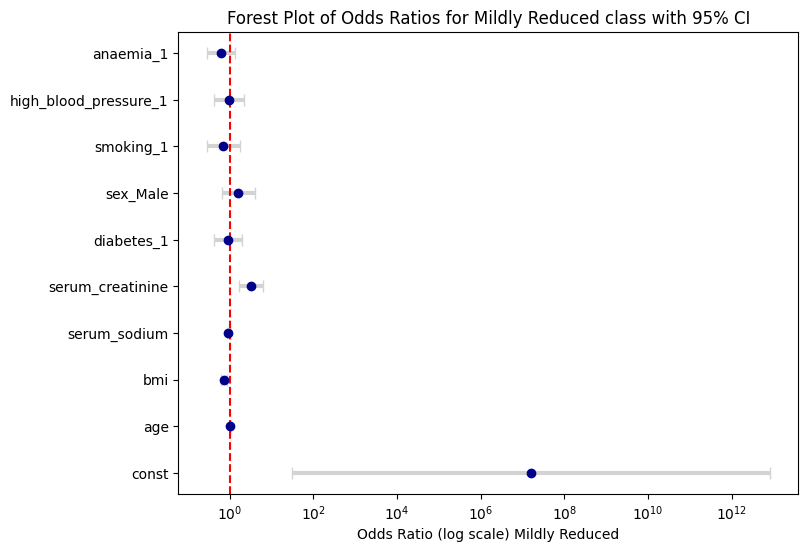

In [42]:
coef = result.params[0]
odds_ratios = np.exp(coef)

conf = result.conf_int().loc['mildly reduced']
conf.columns = ['2.5%', '97.5%']
conf = np.exp(conf)  # Exponentiate to get ORs' CIs

or_summary = pd.DataFrame({
    "Coefficient Mildly Reduced": coef,
    "Odds Ratio Mildly Reduced": odds_ratios,
    "2.5% CI OR Mildly Reduced": conf['2.5%'],
    "97.5% CI OR Mildly Reduced": conf['97.5%']
})

fig, ax = plt.subplots(figsize=(8, len(or_summary) * 0.6))

ax.errorbar(or_summary['Odds Ratio Mildly Reduced'], or_summary.index,
            xerr=[or_summary['Odds Ratio Mildly Reduced'] - or_summary['2.5% CI OR Mildly Reduced'], or_summary['97.5% CI OR Mildly Reduced'] - or_summary['Odds Ratio Mildly Reduced']],
            fmt='o', color='darkblue', ecolor='lightgray', elinewidth=3, capsize=4)

ax.axvline(1, color='red', linestyle='--')

ax.set_xlabel("Odds Ratio (log scale) Mildly Reduced")
ax.set_title("Forest Plot of Odds Ratios for Mildly Reduced class with 95% CI")
ax.set_xscale("log")  # Log scale for better visualization

plt.show()

## Test set evaluation

In [43]:
y_test_pred_prob = result.predict(X_test)  # Returns probabilities for each class
y_test_pred_prob

,0,1,2
170,0.95,0.04,0.01
237,0.89,0.10,0.01
218,0.88,0.10,0.01
228,0.88,0.12,0.00
264,0.19,0.25,0.55
129,0.46,0.23,0.31
97,0.12,0.12,0.77
139,0.77,0.18,0.05
193,0.92,0.07,0.00
39,0.91,0.08,0.01


In [44]:
y_test_pred_prob.rename(model._ynames_map, axis='columns', inplace=True)

y_test_pred_class = y_test_pred_prob.idxmax(axis=1) #for each sample, assign the class with maximum probability

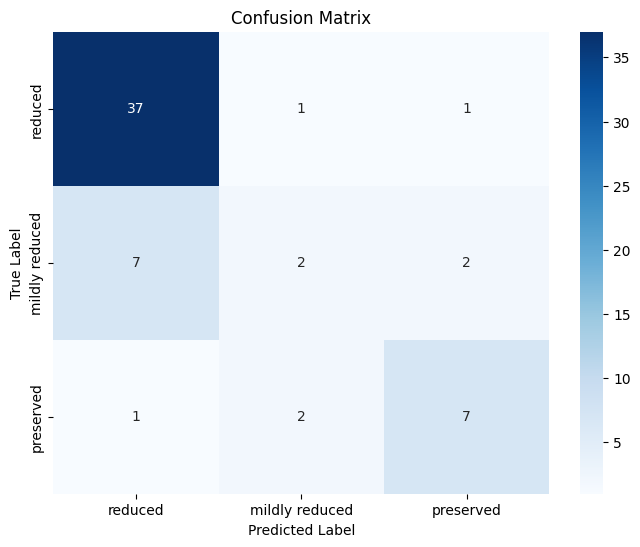

In [45]:
cm = confusion_matrix(y_test, y_test_pred_class, labels=list(model._ynames_map.values()))

class_names = model._ynames_map.values()

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [46]:
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_class))


Classification Report:
                precision    recall  f1-score   support

mildly reduced       0.40      0.18      0.25        11
     preserved       0.70      0.70      0.70        10
       reduced       0.82      0.95      0.88        39

      accuracy                           0.77        60
     macro avg       0.64      0.61      0.61        60
  weighted avg       0.72      0.77      0.74        60



In a multiclass context, the ROC-AUC can be computed per class with a one-vs-all approach

In [47]:
# Compute ROC AUC for each class (one-vs-all)
roc_auc_scores = {}
for i in (y_test_pred_prob.columns):
    roc_auc = roc_auc_score(y_test == i, y_test_pred_prob.loc[:, i])  # Treat class i as positive
    roc_auc_scores[i] = roc_auc

# Output the ROC AUC scores
for class_name, auc in roc_auc_scores.items():
    print(f'ROC AUC for {class_name}: {auc:.2f}')

ROC AUC for reduced: 0.93
ROC AUC for mildly reduced: 0.73
ROC AUC for preserved: 0.95


An aggregate ROC-AUC can be computed in different ways

In [48]:
y_test = y_test.map({'reduced': 0, 'mildly reduced': 1, 'preserved': 2})
y_test_pred_prob.rename(columns={'reduced': 0, 'mildly reduced': 1, 'preserved': 2}, inplace=True)

roc_auc_micro = roc_auc_score(y_test, y_test_pred_prob, average='micro', multi_class='ovr')
print(f'Micro-average ROC AUC: {roc_auc_micro:.2f}')

roc_auc_micro = roc_auc_score(y_test, y_test_pred_prob, average='macro', multi_class='ovr')
print(f'Macro-average ROC AUC: {roc_auc_micro:.2f}')

roc_auc_micro = roc_auc_score(y_test, y_test_pred_prob, average='weighted', multi_class='ovr')
print(f'Weighted-average ROC AUC: {roc_auc_micro:.2f}')

Micro-average ROC AUC: 0.92
Macro-average ROC AUC: 0.87
Weighted-average ROC AUC: 0.89


\begin{array}{|c|c|c|c|}
\hline
\textbf{Aspect} & \textbf{Macro-Averaging} & \textbf{Micro-Averaging} & \textbf{Weighted Averaging} \\
\hline
\textbf{Calculation} & \text{Average of individual class metrics} & \text{Aggregated metrics across all classes} & \text{Average of class metrics weighted by class size} \\
\hline
\textbf{Class Weighting} & \text{Treats all classes equally} & \text{Larger classes have more influence} & \text{Larger classes influence the average more} \\
\hline
\textbf{Performance Insight} & \text{Insight into performance of each class} & \text{Overall performance across the entire dataset} & \text{Balanced evaluation considering class sizes} \\
\hline
\textbf{Sensitivity} & \text{Sensitive to class imbalance} & \text{More robust to class imbalance} & \text{Moderately sensitive to class imbalance} \\
\hline
\textbf{Use Cases} & \text{Class-specific performance} & \text{Overall model performance} & \text{Balanced performance in imbalanced datasets} \\
\hline
\end{array}


$$
\text{Precision}_{\text{micro}} = \frac{\sum_{i=1}^{C} \text{TP}_i}{\sum_{i=1}^{C} (\text{TP}_i + \text{FP}_i)}
$$

$$
\text{Recall}_{\text{micro}} = \frac{\sum_{i=1}^{C} \text{TP}_i}{\sum_{i=1}^{C} (\text{TP}_i + \text{FN}_i)}
$$

$$
\text{F1}_{\text{micro}} = 2 \times \frac{\text{Precision}_{\text{micro}} \times \text{Recall}_{\text{micro}}}{\text{Precision}_{\text{micro}} + \text{Recall}_{\text{micro}}}
$$


Use macro when:

*  You care about per-class behavior, and you want to treat all classes equally, regardless of their frequency.

*  You want to evaluate model fairness across all classes, including rare or underrepresented ones.

*  You're dealing with imbalanced data, and you want to make sure small classes still matter in the evaluation.

*  You want to highlight weaknesses in your model’s performance on rare classes.



Use micro when:

*  You don't care about classes individually.

* You only care about total prediction quality.

* You are working with highly multilabel settings (many labels per sample).

* You want one simple number for "How many labels did I guess right?".

Use weighted when:

* You do care about per-class behavior.

* You want a summary that adjusts for imbalance but still thinks per-class.

* You have imbalanced classes, but you still want per-class precision/recall insight.

## Change baseline class

Manually encoding the target variable allows us to change the order of the numerical labels and consequently change the variable used as base

In [49]:
df_encoded = pd.get_dummies(df, columns=cat_vars, drop_first=True, dtype=int)
df_encoded['ef_cat'] = pd.Categorical(df['ef_cat'], categories=['mildly reduced', 'preserved', 'reduced'], ordered=True)

In [50]:
X = df_encoded[['age', 'bmi', 'serum_sodium', 'serum_creatinine', 'diabetes_1', 'sex_Male', 'smoking_1', 'high_blood_pressure_1', 'anaemia_1']]
y = df_encoded['ef_cat']  # Multiclass target variable

X = sm.add_constant(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234, stratify=y)

In [51]:
model = sm.MNLogit(y_train, X_train)
result = model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.625371
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                 ef_cat   No. Observations:                  239
Model:                        MNLogit   Df Residuals:                      219
Method:                           MLE   Df Model:                           18
Date:                Sun, 13 Jul 2025   Pseudo R-squ.:                  0.2901
Time:                        15:48:21   Log-Likelihood:                -149.46
converged:                       True   LL-Null:                       -210.53
Covariance Type:            nonrobust   LLR p-value:                 1.657e-17
     ef_cat=preserved       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     7.8485      8.602      0.912      0.362      -9.011      24.

In [52]:
np.exp(result.params).rename(columns={0: 'preserved OR', 1:'reduced OR'})

,preserved OR,reduced OR
const,2561.99,0.00
age,0.97,0.98
bmi,0.57,1.40
serum_sodium,1.04,1.09
serum_creatinine,3.89,0.32
diabetes_1,2.00,1.09
sex_Male,0.60,0.63
smoking_1,2.03,1.43
high_blood_pressure_1,0.77,1.05
anaemia_1,2.25,1.64
